# Testes Estatisticos Cruzadas Bot

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from Trie import Trie
from Gaddag import Gaddag
from Palavras_Cruzadas import Palavras_Cruzadas
from Cruzadas_Bot import Bot
from Cruzadas_Bot_Gaddag import Gaddag_Bot

Vamos executar 100 partidas entre bots otimistas e gerar algumas estatisticas

In [7]:
path = "br-sem-acentos.txt"
trie = Trie(path)
gaddag = Gaddag(path)

In [8]:
def rodar_partida(prints: bool=False, seed: int=None):
    """Executa uma partida e armazena seus dados"""

    jogo = Palavras_Cruzadas(trie, seed=seed)
    bot = Gaddag_Bot( jogo.tabuleiro, trie, gaddag )

    jogadas_partida = []
    try:
        if prints: jogo.print_cenario()
        while True:
            jogada, jogadas = bot.escolhe_melhor_jogada(jogo.get_letras_jogador_atual(), jogo.tabuleiro.pos_vaga(7, 7))
            jogadas_partida.append((jogo.contador_jogadas, jogadas))
            if prints: jogo.print_cenario(tabuleiro=False)
            #print(jogada)
            jogo.fazer_jogada(jogada[0], jogada[1], jogada[2], jogada[3], jogada[4])
            #jogo.fazer_jogada(jogada[0][0], jogada[0][1], jogada[0][2], jogada[0][3], jogada[2])
            if prints: jogo.print_cenario(infos_jogadores=False, saco_letras=False)
            if prints: print(jogada)
            if jogo.finalizado:
                if prints: jogo.print_cenario(tabuleiro=False)
                if jogo.get_infos()["Pontos jogadores"][0]<1 or jogo.get_infos()["Pontos jogadores"][1]<1:
                    raise Exception("negativo parca!")
                break
            if prints: time.sleep(1)
    except:
        raise Exception(f"Nao sei qual o erro mas a seed eh {jogo.seed}")
    infos = jogo.get_infos()
    return infos, jogadas_partida

In [9]:
num_partidas = 500
dados_partidas = [0] * num_partidas
jogadas_partidas = [0] * num_partidas
for i in range(num_partidas):
    dados_partida, jogadas = rodar_partida(seed=i)
    dados_partidas[i] = dados_partida
    jogadas_partidas[i] = jogadas
    #print(i)

#print(dados_partidas)
#print(jogadas_partidas)


Fazer clusterização da distribuição das letras em cada mão para entender as jogadas q o bot faz

In [10]:
df = pd.DataFrame(dados_partidas)

novas_colunas = pd.DataFrame(df['Pontos jogadores'].to_list(), columns=["Pontos 0", "Pontos 1"], index=df.index)

diferenca = pd.DataFrame(novas_colunas['Pontos 1'] - novas_colunas['Pontos 0'], columns=["Diferenca"])

func = lambda t: t/abs(t) if t!=0 else 0
ganhador = pd.DataFrame([func(dif) for dif in diferenca["Diferenca"].to_list()], columns=["Ganhador"])

df.drop("Pontos jogadores", axis=1, inplace=True)

df = pd.concat([novas_colunas, diferenca, ganhador, df], axis=1)

df.head()

#print(df)

,Pontos 0,Pontos 1,Diferenca,Ganhador,Finalizado,Contador_troca_letras,Letras res no saco,Letras res na mao,Jogaodr com letras na mao,Num jogadas,seed
0,451,343,-108,-1.0,True,1,0,1,1,22,0
1,472,405,-67,-1.0,True,0,0,1,0,25,1
2,452,316,-136,-1.0,True,0,0,2,1,24,2
3,410,370,-40,-1.0,True,0,0,1,0,25,3
4,430,446,16,1.0,True,0,0,2,1,26,4


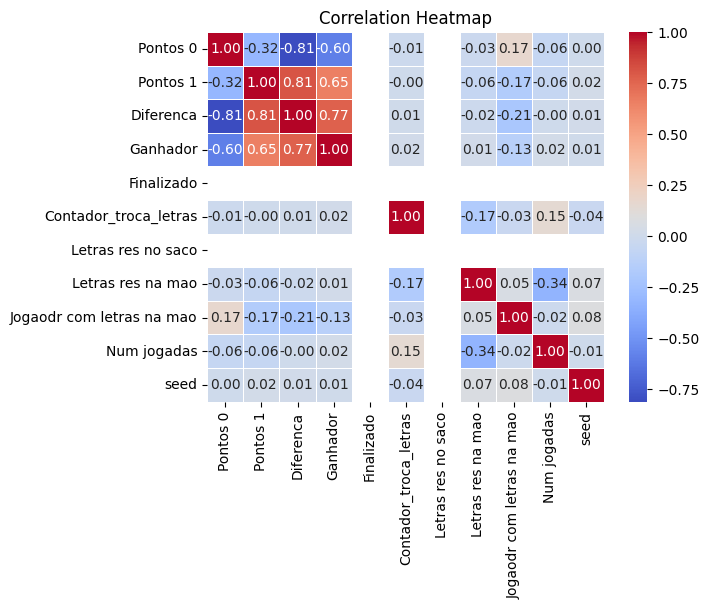

In [11]:
matrix = df.corr()

sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

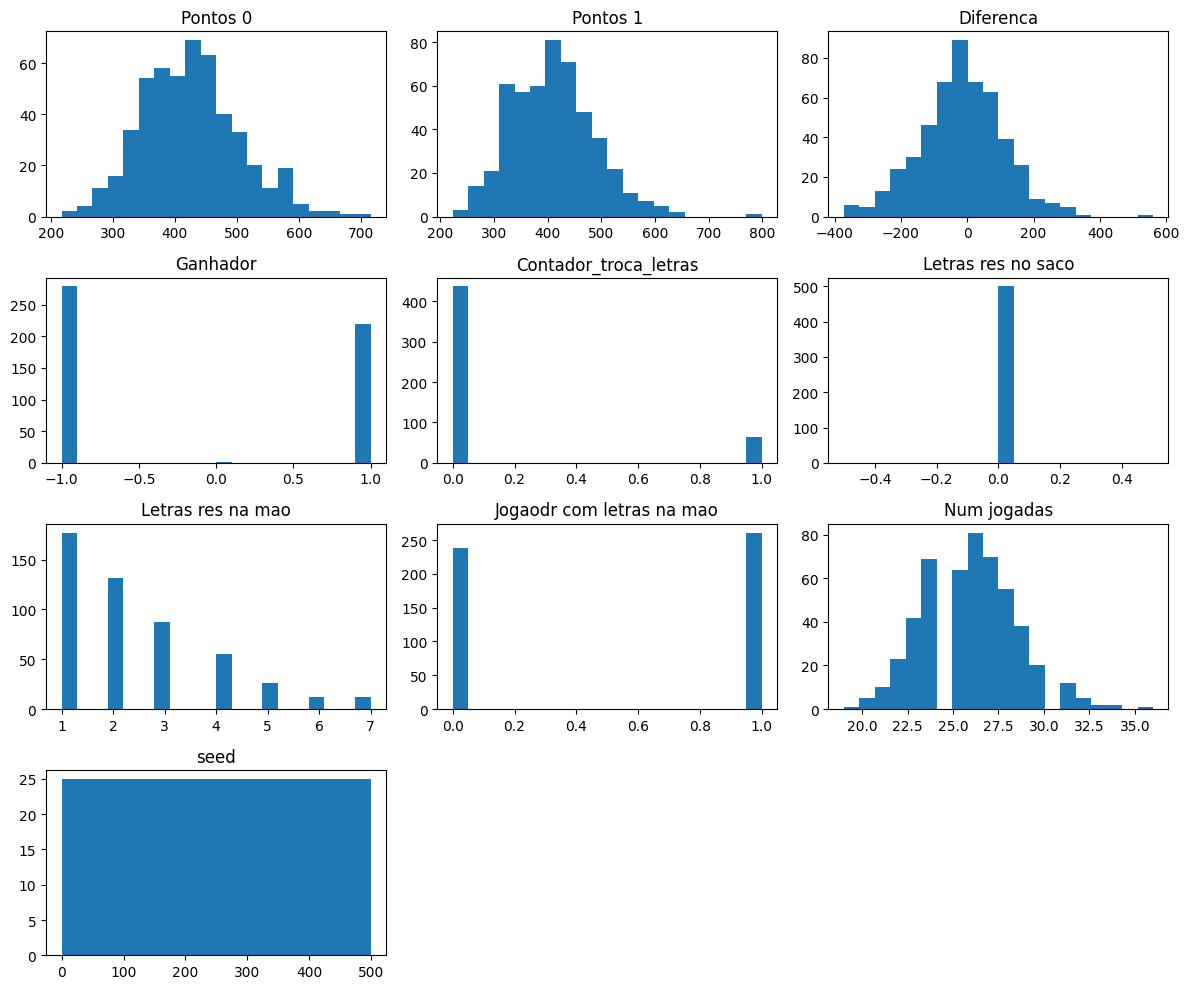

In [17]:
df.hist(bins=20, figsize=(12, 10), grid=False)
plt.tight_layout()

In [13]:
partidas = []
lances = []

for i, partida in enumerate(jogadas_partidas):
    partidas.append({"Seed": i})
    for jogadas in partida:
        pontos_lance = [ponto[4] for ponto in jogadas[1]]
        lances.append({"Seed" : i,
                        "Ganhador Partida" : df.iloc[i]["Ganhador"],
                        "Diferenca" : df.iloc[i]["Diferenca"],
                        "Contador do lance" : jogadas[0],
                        "Num de lances Disponiveis" : len(jogadas[1]),
                        "Media pontos" : sum(pontos_lance),
                        "Maior pontuacao" : max(pontos_lance),
                        "Num palavras maxima" : pontos_lance.count(max(pontos_lance))})

df_lances = pd.DataFrame(lances)
jogadas_partidas = None

In [14]:
df_lances.head()

,Seed,Ganhador Partida,Diferenca,Contador do lance,Num de lances Disponiveis,Media pontos,Maior pontuacao,Num palavras maxima
0,0,-1.0,-108,0,648,8748,32,2
1,0,-1.0,-108,1,187,1517,21,2
2,0,-1.0,-108,2,182,1661,26,3
3,0,-1.0,-108,3,225,2171,22,8
4,0,-1.0,-108,4,180,1527,24,1


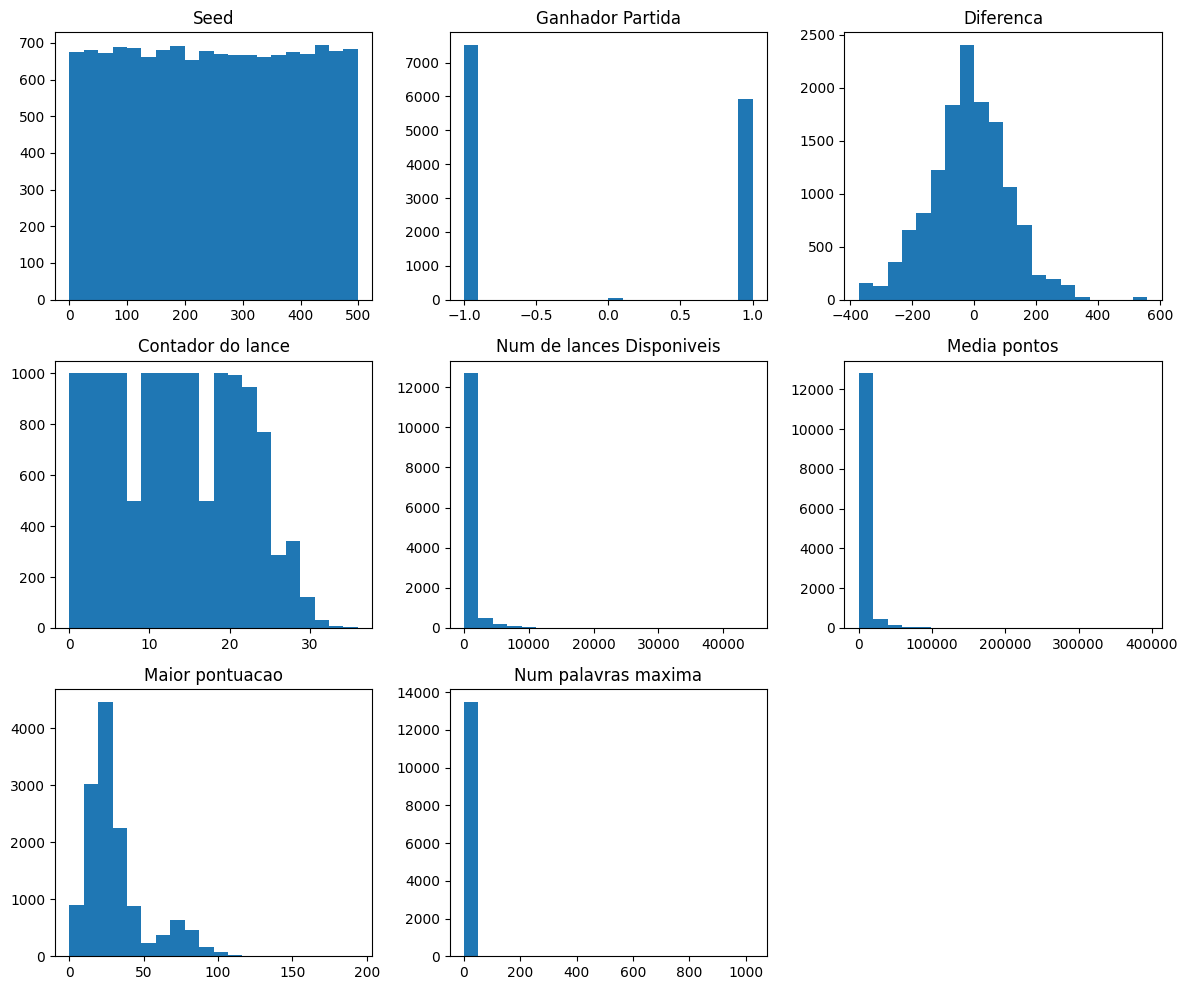

In [15]:
df_lances.hist(bins=20, figsize=(12, 10), grid=False)
plt.tight_layout()